# Information
Title: Artificial Intelligence in Insurance Claims Management - Computer vision for car damage recognition 

Author: Roman Kastl

# Training & Fine-tuning EfficientNetB0 - Module 1 - vF
- Use transfer learning to classify images of damaged vs. non-damaged car
- EfficientNetB0


# Build, train, and save models

## Preparation

### Import the required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import os
import pathlib
import PIL
import random
import json
import datetime

#Only if we use colab
#from google.colab import files
from tensorflow.python.client import device_lib
import torch

#Import tensorboard plugins
import tensorboard as tb
from scipy import stats
from tensorboard.plugins.hparams import api as hp
from packaging import version
import seaborn as sns

#Library for model scheme
import pydot
import graphviz
import pydotplus

#Require tensorflow >= 2.3
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
import tensorflow_addons as tfa
print(tf.__version__)

2.4.0


In [29]:
model_version = "vF"
step_name ="Training and Fine-tuning"
module_name = "Module1"
drive_path = "/content/drive/My Drive/Colab Notebooks/"+step_name+"/"+module_name+"/"+model_version+"/"
load_drive = True
save_plot = True
save_data = True
save_history = True

In [4]:
from google.colab import drive
if load_drive == True:
  drive.mount('/content/drive')

Mounted at /content/drive


### Set seed value

In [5]:
# Set the Random Seed
seed_value= 123

os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

### Check that model will run on GPU

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jan 12 17:21:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from tensorflow.python.client import device_lib
import torch

torch.cuda.is_available()
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5734172007751716155, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15469833088
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4542089176091846936
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [8]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)

# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Num GPUs Available:  1
tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


## Part 1 - Data Preprocessing


### - Recover data

From Google drive

In [9]:
#!gdown --id 1_EEaL9XamxtaO2TC2O02wU_8MdIB-A7d
dataset_name = "Dataset_v1_bin_damage"
!tar -xvf  '/content/drive/MyDrive/Colab Notebooks/Thesis_dataset/Module1.tar.gz' -C '/content'
data_dir = pathlib.Path("/content/"+dataset_name)

Dataset_v1_bin_damage/
Dataset_v1_bin_damage/car/
Dataset_v1_bin_damage/car-damaged/
Dataset_v1_bin_damage/car-damaged/car-damaged_0.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_10.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_100.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1000.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1001.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1002.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1003.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1004.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1005.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1006.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1007.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1008.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1009.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_101.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged_1010.jpg
Dataset_v1_bin_damage/car-damaged/car-damaged

### - Count the number of existing image and display

In [10]:
#count the total number of image
image_count = len(list(data_dir.glob('*/*/')))
print(image_count)

2299


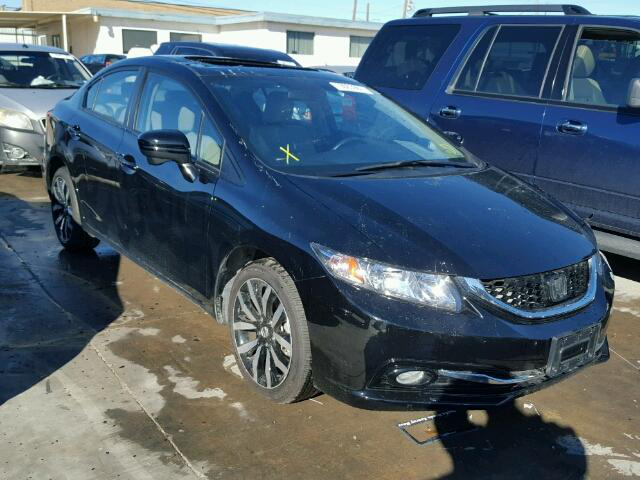

In [16]:
#Display a car
car_image = list(data_dir.glob('*/*/'))
PIL.Image.open(str(car_image[5]))

### Pre-process the images and prepare the training, validation and test set
This part split the dataset in a training (80%) and test dataset (20%)

In [17]:
#Preprocess the picture and prepare the set keras
#batch_size = 64
batch_size = 32
img_size = (224,224)

In [18]:
#Generate a training and validation dataset, in the next cell, a test dataset is generated from the validation dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  label_mode='categorical',
  image_size= img_size ,
  shuffle=True,
  batch_size=batch_size)
  
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  label_mode='categorical',
  image_size=img_size,
  shuffle=True,
  batch_size=batch_size)

Found 2299 files belonging to 2 classes.
Using 1840 files for training.
Found 2299 files belonging to 2 classes.
Using 459 files for validation.


In [19]:
#Skip the test set and only use a training and validation set for Module 2 and 3, due to the limited quantity of training data

#As not test dataset is available, we will extract a few pictures from the validation dataset
#source https://www.tensorflow.org/tutorials/images/transfer_learning
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 12
Number of test batches: 3


In [20]:
target_dict={k: v for v, k in enumerate(np.unique(train_ds.class_names))}
class_names = np.array(train_ds.class_names)
num_classes = len(class_names)
print(class_names)
print(num_classes)

['car' 'car-damaged']
2


### Display a few images of each class

As we can observed, 0 refers to the damage class and 1 to regular car pictures

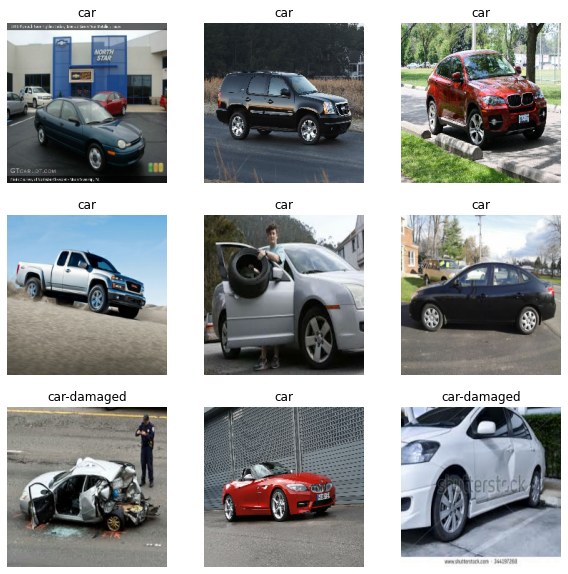

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

In [22]:
#Print dataset format
# Here we use a batch of 32, the image dimensions are 224x224 and RGB (3)
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32, 2)


### Configure dataset for performance

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

## Part 2 - Build the model

### Build Callbacks and Training method

Callback: 

- EarlyStopping: Stop training the model if loss on validation set has not improved over 3 iterations
- ModelCheckpoint: Save the best model based on the validation accuracy
- WIP - TensorBoard: Generate the data for a tensorboard 


Model:
- EfficientNet-B0

In [24]:
def train_model(model_to_train,callbacks, epochs):
    model_to_train
    history_model_to_train = model_to_train.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    return(model_to_train,history_model_to_train)

In [25]:
### COMPILE THE MODEL
if num_classes == 2:
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    METRICS = [
             'accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),             
             tfa.metrics.F1Score(name='f1-score',average='macro',num_classes=num_classes,threshold=0.5),
             ]
else:
    loss_func = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    METRICS = [
             'accuracy',
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),             
             tfa.metrics.F1Score(name='f1-score',average='macro',num_classes=num_classes,threshold=0.5),
             tfa.metrics.F1Score(name='f1-score_perClass',num_classes=num_classes,threshold=0.5)             
             ]

In [31]:
def build_callback(model_name, patience, verbose):
    callbacks_list = [
     keras.callbacks.EarlyStopping(
         monitor="val_loss",
         patience=patience,
         verbose=verbose,
         mode="auto",
         restore_best_weights=True,
     ),
      keras.callbacks.TensorBoard(
          log_dir="logs/fit/"+model_name,
          histogram_freq=1,
          embeddings_freq=1,
          )]
    if save_data == True:
      {
        callbacks_list.append(
         keras.callbacks.ModelCheckpoint(
         filepath=drive_path+""+model_name+".h5",
         monitor="val_loss",
         save_best_only=True,
     ))
      }

    return(callbacks_list)


### Data augmentation

In this code data augmentation is achieved through layers which are added to the model

In [32]:
#Create layer for image augmentation
#It will help to prevent overfitting
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.15),
    layers.experimental.preprocessing.RandomZoom(0.1),
    ]
)

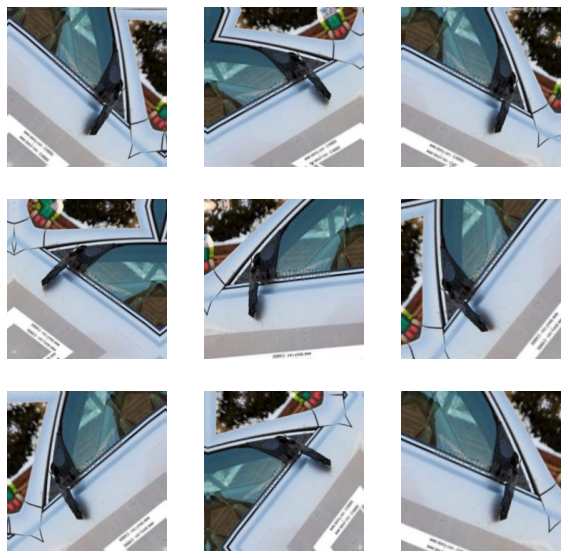

In [33]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Build and Compile EfficientNetB0
- Initialize
- Pass Data augmentation
- Rescale /255, /127.5 and 0;1 or -1;1 depending on the model transferred
- Output layer - Sigmoid function (Binary output)
### Model inspired from:

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

https://www.tensorflow.org/tutorials/images/transfer_learning

https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/


In [34]:
from tensorflow.keras.applications import EfficientNetB0

#Make the EfficientNetB0 model
def make_model_EfficientNetB0(input_shape, num_classes, model_arch_name):

    ### BUILD THE MODEL
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    preprocess_input_EfficientNetB0 = keras.applications.efficientnet.preprocess_input
    x = preprocess_input_EfficientNetB0(x)
    
    #We do not want the base to be trainable, otherwise we would lose all the advantagres of using pre-trained model
    #conv_base_EfficientNetB0  = EfficientNetB0(weights='imagenet',include_top=False,input_tensor=x, drop_connect_rate=0.2)      
    conv_base_EfficientNetB0  = EfficientNetB0(weights='imagenet',include_top=False,input_tensor=x)      
    conv_base_EfficientNetB0.trainable = False
    conv_base_EfficientNetB0.summary()

    #x = conv_base_EfficientNetB0(x)

    #Rebuild top, starting with a GlobalMaxPooling in order to convert the feature maps in vectors
    x = keras.layers.GlobalMaxPooling2D(name="top_GlobalMaxPooling2D")(conv_base_EfficientNetB0.output)
    x = layers.BatchNormalization(name="topBatchNorm")(x)

    dropout_rate = 0.5
    x = layers.Dropout(dropout_rate, name="top_dropout")(x)    

    activation = "softmax"
    units = num_classes

    outputs = layers.Dense(units, activation=activation, name="pred")(x)
    model = keras.Model(inputs, outputs, name="EfficientNetB0")
    
    #would use 1e-5 for fine-tuning
    #a learning rate of 1e-2 reduced the valuation f1
    opt = Adam(lr=1e-3)
    
    model.compile(optimizer=opt, loss=loss_func, metrics=METRICS)
    
    #model.summary()
    if (save_plot == True):
      keras.utils.plot_model(model,show_shapes=True,to_file=drive_path+model_arch_name+"_plot.png")
    return(model)

### Build chart to evaluate the model training process

In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#evaluate_metrics

In [35]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history, key):
  metrics =  ['accuracy','loss','f1-score']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history[metric], color=colors[0], label='Train')
    plt.plot(history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend()
    fig = plt.gcf()
    if(save_data == True):
      fig.savefig(drive_path+key+"_training_plot.png", dpi=300)

### JSON export

In [36]:
def json_export(name, data):
  df = pd.DataFrame.from_dict(data)
  csv_path = drive_path+module_name+"_"+model_version+"_history_df_"+name+".csv"
  df.to_csv(csv_path, index=False)

## Part 3 - Compile, train and assess EfficientNet-B0
Can only run one of the below, must restart the session in between the compilation of two model. The goal is to uniform the tests

###Compile and summary of EfficientNet-B0

In [38]:
model_EfficientNetB0 = make_model_EfficientNetB0(img_size+(3,),num_classes, "EfficientNetB0")
model_EfficientNetB0.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           sequential_1[0][0]               
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
____________________

### Train EfficientNetB0

In [40]:
#Set to 30 because we do not want early stopping for cause of Visual rendering, but we still use early stopping in order to restore the best weights
epochs = 30
patience = 30
verbose = 1

callbacks_EfficientNetB0 = build_callback("EfficientNetB0", patience, verbose)
model_EfficientNetB0, history_model_EfficientNetB0 = train_model(model_EfficientNetB0, callbacks_EfficientNetB0, epochs)
# Save it under the form of a json file
if save_history == True:
  json_export("EfficientNetB0", history_model_EfficientNetB0.history)

Epoch 1/30
58/58 [==============================] - 16s 99ms/step - loss: 0.8714 - accuracy: 0.6573 - precision: 0.6573 - recall: 0.6573 - f1-score: 0.6569 - val_loss: 0.9351 - val_accuracy: 0.6997 - val_precision: 0.6997 - val_recall: 0.6997 - val_f1-score: 0.6810
Epoch 2/30
58/58 [==============================] - 2s 41ms/step - loss: 0.4621 - accuracy: 0.8165 - precision: 0.8165 - recall: 0.8165 - f1-score: 0.8164 - val_loss: 0.4700 - val_accuracy: 0.8154 - val_precision: 0.8154 - val_recall: 0.8154 - val_f1-score: 0.8129
Epoch 3/30
58/58 [==============================] - 2s 41ms/step - loss: 0.3576 - accuracy: 0.8662 - precision: 0.8662 - recall: 0.8662 - f1-score: 0.8661 - val_loss: 0.2907 - val_accuracy: 0.8898 - val_precision: 0.8898 - val_recall: 0.8898 - val_f1-score: 0.8898
Epoch 4/30
58/58 [==============================] - 2s 41ms/step - loss: 0.3647 - accuracy: 0.8433 - precision: 0.8433 - recall: 0.8433 - f1-score: 0.8433 - val_loss: 0.2796 - val_accuracy: 0.8953 - val_p

In [41]:
history_model_EfficientNetB0.history

{'accuracy': [0.740217387676239,
  0.8195652365684509,
  0.863043487071991,
  0.8500000238418579,
  0.8608695864677429,
  0.8717391490936279,
  0.866304337978363,
  0.8880434632301331,
  0.8788043260574341,
  0.8711956739425659,
  0.8804348111152649,
  0.8798912763595581,
  0.873369574546814,
  0.8907608985900879,
  0.885869562625885,
  0.895108699798584,
  0.8777173757553101,
  0.8788043260574341,
  0.883695662021637,
  0.8918478488922119,
  0.898369550704956,
  0.895108699798584,
  0.904891312122345,
  0.8923913240432739,
  0.897826075553894,
  0.898369550704956,
  0.893478274345398,
  0.8929347991943359,
  0.8929347991943359,
  0.8907608985900879],
 'f1-score': [0.7401483058929443,
  0.8195649981498718,
  0.8630377054214478,
  0.8499935865402222,
  0.8608531951904297,
  0.8717389702796936,
  0.8662885427474976,
  0.8880401849746704,
  0.8787999749183655,
  0.871191143989563,
  0.8804256916046143,
  0.8798912763595581,
  0.8733611702919006,
  0.8907569646835327,
  0.8858661651611328,

### Chart the model EfficientNet-B0

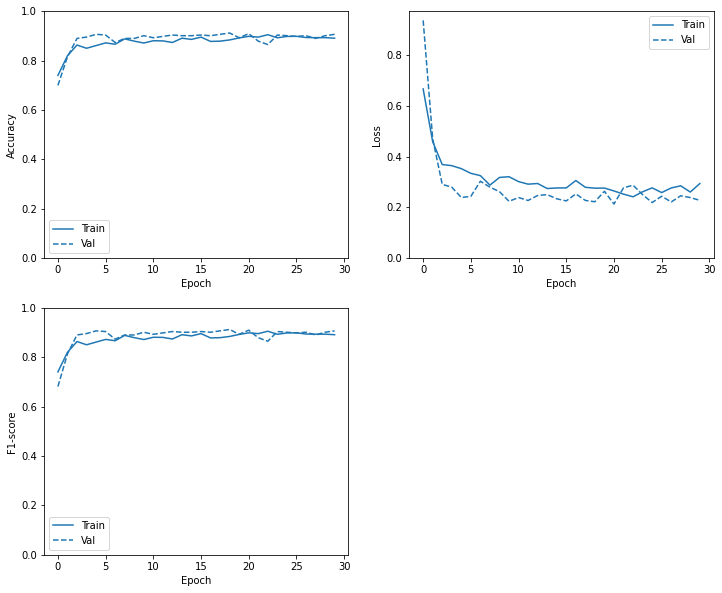

In [42]:
# Read the Json
#history_dict_EfficientNetB0 = json.load(open("history_dict_EfficientNetB0.json", 'r'))
mpl.rcParams['figure.figsize'] = (12, 10)
plot_metrics(history_model_EfficientNetB0.history,"EfficientNetB0")

## Part 4 - Fine-tune the model

Source: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

### Determine layers to unfreeze

In [45]:
 #model_EfficientNetB0.summary()
for layer in model_EfficientNetB0.layers[-9:]:
  print(layer)

### Build unfreeze_model method

In [46]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers, corresponding to the Block 7 of the EfficientNet-B0 model, use 21 if the Dense 128 layer is added on top
    for layer in model.layers[-9:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    #would use 1e-5 for fine-tuning
    opt = Adam(lr=1e-4)
    
    model.compile(optimizer=opt, loss=loss_func, metrics=METRICS)

unfreeze_model(model_EfficientNetB0)

In [47]:
model_EfficientNetB0.summary()

Model: "EfficientNetB0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           sequential_1[0][0]               
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
_____________________________________________________________________________________

### Train the fine-tuned model

In [48]:
#Set to 10 because we do not want early stopping for cause of Visual rendering, but we still use early stopping in order to restore the best weights
epochs = 30
patience = 30
verbose = 1

callbacks_EfficientNetB0 = build_callback("EfficientNetB0_ft", patience, verbose)
model_EfficientNetB0, history_model_EfficientNetB0 = train_model(model_EfficientNetB0, callbacks_EfficientNetB0, epochs)
# Save it under the form of a json file
if save_history == True:
  json_export("EfficientNetB0_ft", history_model_EfficientNetB0.history)

Epoch 1/30
58/58 [==============================] - 11s 89ms/step - loss: 0.2602 - accuracy: 0.8978 - precision: 0.8994 - recall: 0.8994 - f1-score: 0.8994 - val_loss: 0.2344 - val_accuracy: 0.9036 - val_precision: 0.9036 - val_recall: 0.9036 - val_f1-score: 0.9035
Epoch 2/30
58/58 [==============================] - 2s 41ms/step - loss: 0.2508 - accuracy: 0.8868 - precision: 0.8868 - recall: 0.8868 - f1-score: 0.8867 - val_loss: 0.2254 - val_accuracy: 0.9036 - val_precision: 0.9036 - val_recall: 0.9036 - val_f1-score: 0.9035
Epoch 3/30
58/58 [==============================] - 2s 42ms/step - loss: 0.2118 - accuracy: 0.9040 - precision: 0.9040 - recall: 0.9040 - f1-score: 0.9040 - val_loss: 0.2523 - val_accuracy: 0.9036 - val_precision: 0.9036 - val_recall: 0.9036 - val_f1-score: 0.9035
Epoch 4/30
58/58 [==============================] - 2s 42ms/step - loss: 0.1941 - accuracy: 0.9233 - precision: 0.9233 - recall: 0.9233 - f1-score: 0.9232 - val_loss: 0.2147 - val_accuracy: 0.9146 - val_p

### Chart the fine-tuned model

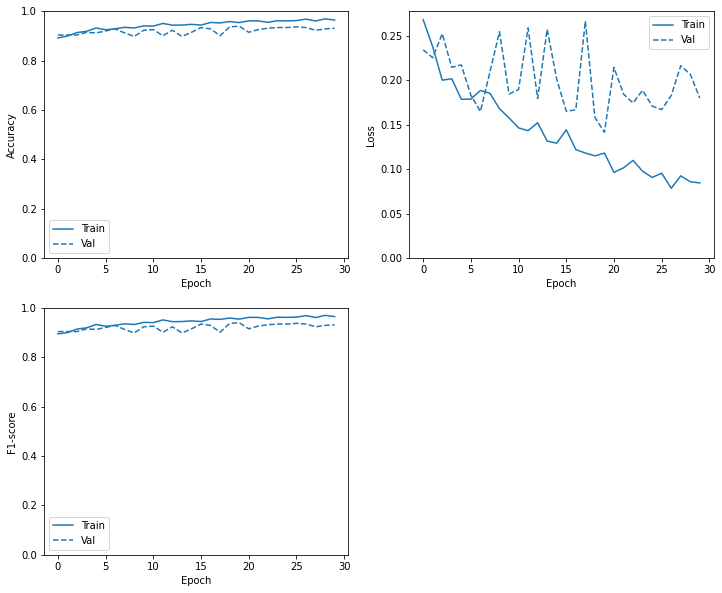

In [49]:
# Read the Json
#history_dict_EfficientNetB0 = json.load(open("history_dict_EfficientNetB0.json", 'r'))
mpl.rcParams['figure.figsize'] = (12, 10)
plot_metrics(history_model_EfficientNetB0.history,"EfficientNetB0_ft")

# Tensorboard

In [ ]:
#https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb#scrollTo=Ycz766H-zSwh

#!rm -rf ./logs/fit/VGG16_20201217-113236
#!tensorboard dev list
#!tensorboard dev delete --experiment_id 5zMkplkwTaSjc4WvnzFE1g

In [51]:
#Update to Tensorboard
!tensorboard dev upload --logdir ./logs \
  --name "Training & Fine-tuning - Module 1 - vF" \
  --description "EfficientNet-B0 - Max Pooling, Batch Normalization, Dropout = 0.5" \
  --one_shot

2021-01-12 17:35:49.653066: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&sc

## Access Tensorboard and build chart

https://www.tensorflow.org/tensorboard/dataframe_api

In [52]:
experiment_id = "xVir4RmDQ3mQajYNt8nO5Q"

experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
dfw = experiment.get_scalars(pivot=True) 
dfw

,run,step,epoch_accuracy,epoch_f1-score,epoch_loss,epoch_precision,epoch_recall
0,fit/EfficientNetB0/train,0,0.740217,0.740148,0.665755,0.740217,0.740217
1,fit/EfficientNetB0/train,1,0.819565,0.819565,0.458282,0.819565,0.819565
2,fit/EfficientNetB0/train,2,0.863043,0.863038,0.368444,0.863043,0.863043
3,fit/EfficientNetB0/train,3,0.850000,0.849994,0.364085,0.850000,0.850000
4,fit/EfficientNetB0/train,4,0.860870,0.860853,0.352363,0.860870,0.860870
...,...,...,...,...,...,...,...
115,fit/EfficientNetB0_ft/validation,25,0.936639,0.936639,0.167072,0.936639,0.936639
116,fit/EfficientNetB0_ft/validation,26,0.933884,0.933884,0.182887,0.933884,0.933884
117,fit/EfficientNetB0_ft/validation,27,0.922865,0.922850,0.216445,0.922865,0.922865
118,fit/EfficientNetB0_ft/validation,28,0.928375,0.928370,0.206760,0.928375,0.928375


In [53]:
csv_path = drive_path+module_name+"_"+model_version+"_experiment.csv"
dfw.to_csv(csv_path, index=False)
dfw_roundtrip = pd.read_csv(csv_path)
pd.testing.assert_frame_equal(dfw_roundtrip, dfw)

In [54]:
dfw

,run,step,epoch_accuracy,epoch_f1-score,epoch_loss,epoch_precision,epoch_recall
0,fit/EfficientNetB0/train,0,0.740217,0.740148,0.665755,0.740217,0.740217
1,fit/EfficientNetB0/train,1,0.819565,0.819565,0.458282,0.819565,0.819565
2,fit/EfficientNetB0/train,2,0.863043,0.863038,0.368444,0.863043,0.863043
3,fit/EfficientNetB0/train,3,0.850000,0.849994,0.364085,0.850000,0.850000
4,fit/EfficientNetB0/train,4,0.860870,0.860853,0.352363,0.860870,0.860870
...,...,...,...,...,...,...,...
115,fit/EfficientNetB0_ft/validation,25,0.936639,0.936639,0.167072,0.936639,0.936639
116,fit/EfficientNetB0_ft/validation,26,0.933884,0.933884,0.182887,0.933884,0.933884
117,fit/EfficientNetB0_ft/validation,27,0.922865,0.922850,0.216445,0.922865,0.922865
118,fit/EfficientNetB0_ft/validation,28,0.928375,0.928370,0.206760,0.928375,0.928375


Text(0.5, 1.0, 'loss')

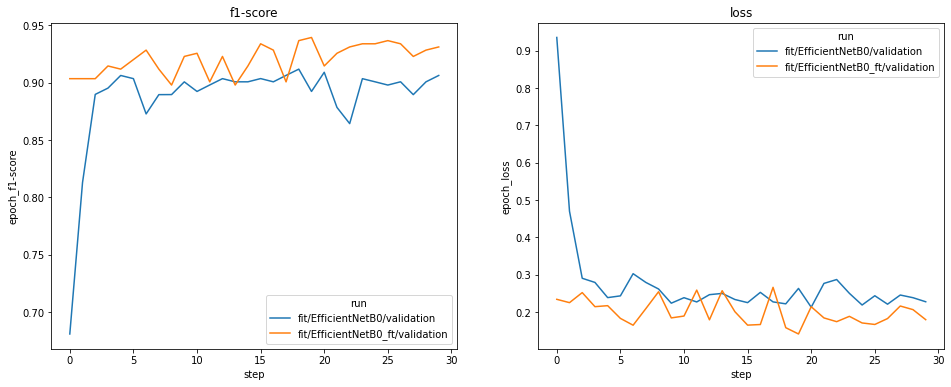

In [55]:
# Filter the DataFrame to only validation data, which is what the subsequent
# analyses and visualization will be focused on.
dfw_validation = dfw[dfw.run.str.endswith("/validation")]
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_validation.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=dfw_validation, x="step", y="epoch_f1-score", 
             hue=optimizer_validation).set_title("f1-score")
plt.subplot(1, 2, 2)
sns.lineplot(data=dfw_validation, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

In [56]:
dfw.groupby('run')['epoch_f1-score'].nlargest(1,)


run                                  
fit/EfficientNetB0/train          22     0.904885
fit/EfficientNetB0/validation     48     0.911792
fit/EfficientNetB0_ft/train       88     0.969020
fit/EfficientNetB0_ft/validation  109    0.939393
Name: epoch_f1-score, dtype: float64

### EfficientNet-B0

In [57]:
dfw_EfficientNetB0 = dfw[dfw.run.str.startswith("fit/EfficientNetB0/")]

Text(0.5, 1.0, 'loss')

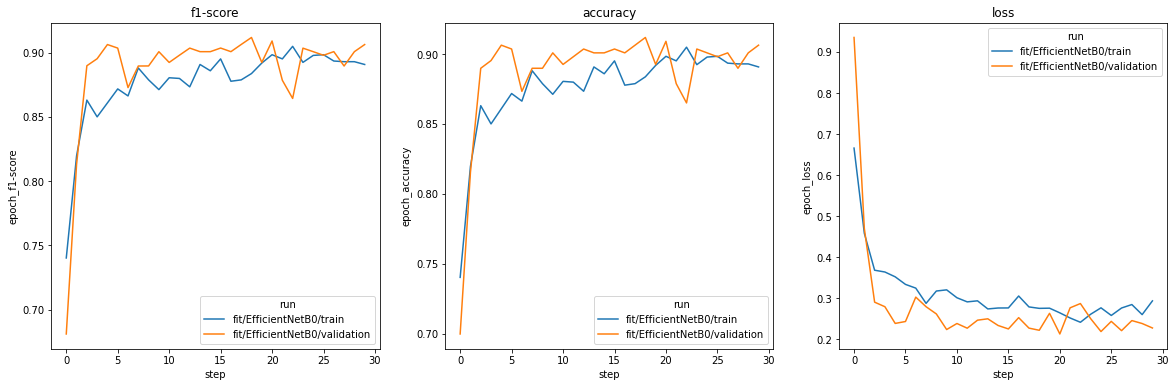

In [67]:
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_EfficientNetB0.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.lineplot(data=dfw_EfficientNetB0, x="step", y="epoch_f1-score", 
             hue=optimizer_validation).set_title("f1-score")
plt.subplot(1, 3, 2)
sns.lineplot(data=dfw_EfficientNetB0, x="step", y="epoch_accuracy",
             hue=optimizer_validation).set_title("accuracy")
plt.subplot(1, 3, 3)
sns.lineplot(data=dfw_EfficientNetB0, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

In [59]:
dfw_EfficientNetB0_ft = dfw[dfw.run.str.startswith("fit/EfficientNetB0_ft")]

Text(0.5, 1.0, 'loss')

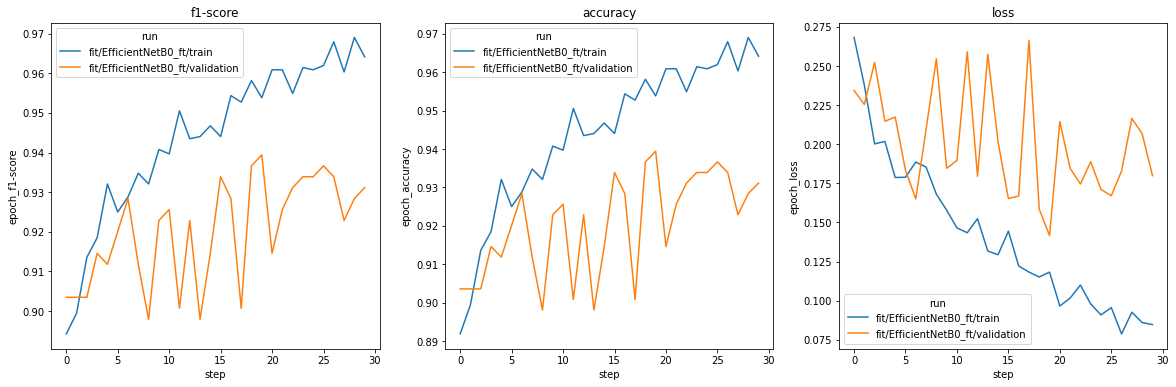

In [68]:
# Get the optimizer value for each row of the validation DataFrame.
optimizer_validation = dfw_EfficientNetB0_ft.run.apply(lambda run: run.split(",")[0])

plt.figure(figsize=(20, 6))
plt.subplot(1, 3, 1)
sns.lineplot(data=dfw_EfficientNetB0_ft, x="step", y="epoch_f1-score", 
             hue=optimizer_validation).set_title("f1-score")
plt.subplot(1, 3, 2)
sns.lineplot(data=dfw_EfficientNetB0_ft, x="step", y="epoch_accuracy",
             hue=optimizer_validation).set_title("accuracy")
plt.subplot(1, 3, 3)
sns.lineplot(data=dfw_EfficientNetB0_ft, x="step", y="epoch_loss",
             hue=optimizer_validation).set_title("loss")

# Load and evaluate models

## Part 1 - Load the model and evaluate its accuracy

In [69]:
model = model_EfficientNetB0
model_name = "EfficientNetB0"


In [70]:
def model_accuracy():
  loss, acc, precision, recall, f1 = model.evaluate(test_ds)
  print('Restored model '+model_name+', accuracy: {:5.2f}%'.format(100*acc))
  print(model.predict(test_ds).shape)

In [72]:
#from https://www.tensorflow.org/tutorials/keras/save_and_load
#model_VGG16 = tf.keras.models.load_model('V2_TRANSFER_VGG16_REDUCED.h5')
# Check its architecture
# model_vgg.summary()
# model_xception.summary()

model_accuracy()

3/3 [==============================] - 1s 107ms/step - loss: 0.2300 - accuracy: 0.9062 - precision: 0.9062 - recall: 0.9062 - f1-score: 0.9062
Restored model EfficientNetB0, accuracy: 90.62%
(96, 2)


## Part 2 - Proceed to multiple predictions


In [73]:
def model_predict():
  #Retrieve a batch of images from the test set
  image_batch, label_batch = test_ds.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch)

  #print('Predictions:\n', predictions)
  #print('Labels:\n', label_batch)

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    x = class_names[np.argmax(label_batch[i])]
    y = class_names[np.argmax(predictions[i])]
    plt.title("Actual:"+ x +"\nPredicted:"+ y +"")
    plt.axis("off")
  return predictions

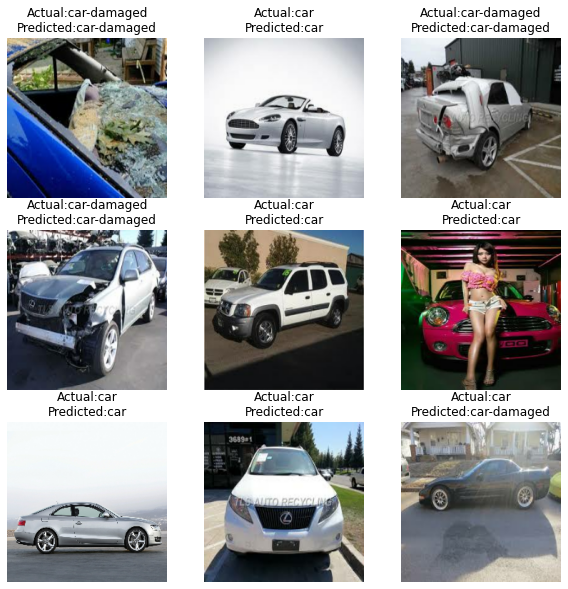

In [74]:
predictions = model_predict()
#Retrieve a batch of images from the test set

In [75]:
#Check
np.sum(predictions, axis=1)

array([1.        , 0.99999994, 0.99999994, 1.        , 0.99999994,
       1.        , 0.99999994, 1.        , 1.        , 0.99999994,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 1.        , 1.        , 1.        ,
       1.0000001 , 0.99999994, 1.        , 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)

## Part 3 - Single Prediction

In [76]:
def model_predict_single():

  prediction = model.predict(img_array)

  #print(f"The alogirthm says this image is:\n {prediction[0,0]:.2%} {class_names[0]}\n and {prediction[0,1]:.2%} {class_names[1]}\n and {prediction[0,2]:.2%} {class_names[2]}\n")
  img.show()

The algorithm says this image is:
 0.04% car
 and 99.96% car-damaged



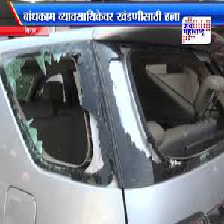

In [78]:
img_path = "/content/Dataset_v1_bin_damage/car-damaged/car-damaged_0.jpg"

img = keras.preprocessing.image.load_img(
      img_path, target_size=img_size
  )

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

prediction = model.predict(img_array)

print(f"The algorithm says this image is:\n {prediction[0,0]:.2%} {class_names[0]}\n and {prediction[0,1]:.2%} {class_names[1]}\n")
img
